# Hotspot Calculations for HEP

Author: Brain Gravelle (gravelle@cs.uoregon.edu)


All this is using the taucmdr python libraries from paratools
http://taucommander.paratools.com/


## Imports

In [1]:
# A couple of scripts to set the environent and import data from a .tau set of results
from utilities import *
from metrics import *
# Plotting, notebook settings:
%matplotlib inline  
#plt.rcParams.update({'font.size': 16})
import numbers
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.float_format', lambda x: '%.2e' % x)
pd.set_option('display.max_columns',100)
pd.set_option('max_colwidth', 70)

## Getting Data

TAU Commander uses TAU to run the application and measure it using runtime sampling techniques (similar to Intel VTune). Many customization options are available. For example, we may consider each function regardless of calling context, or we may decide to enable callpath profiling to see each context separately.

From the talapas_scaling application the following experiments are available. These use Talapas (with 28 thread Broadwell processors) and the build-ce (realistic) option for mkFit
* manual_scaling_Large_talapas		
* manual_scaling_Large_talapas_fullnode	
* manual_scaling_TTbar70_talapas		
* manual_scaling_TTbar70_talapas_fullnode
* manual_scaling_TTbar35_talapas
* manual_scaling_TTbar35_talapas_fullnode
* ev_thr_scaling_Large_talapas
* ev_thr_scaling_Large_talapas_fullnode

Additionally available in the cori_scaling application are the following. These were run on NERSC's Cori on the KNL with the default memory settings. Similar to the talapas scaling they use the build-ce option
* manual_scaling_TTbar35


### Importing Scaling Data

In [2]:
application = "talapas_scaling"
# experiment  = "manual_scaling_TTbar70_talapas"
experiment = "ev_thr_scaling_Large_talapas"

# application = "cori_scaling"
# experiment  = "manual_scaling_TTbar35"

path = ".tau/" + application + "/" + experiment + "/"
# note that this function takes a long time to run, so only rerun if you must
metric_data = get_pandas_scaling(path, callpaths=True)
metric_data = remove_erroneous_threads(metric_data,  [1, 8, 16, 32, 48, 56])
# metric_data = remove_erroneous_threads(metric_data,  [1, 8, 16, 32, 64, 128, 256])

Possible missing metric: 
nthread = 32 
metric = PAPI_BR_INS


In [3]:
print(metric_data.keys())
print_available_metrics(metric_data,True)
select_metric_from_scaling(metric_data, 'PAPI_L2_TCA')

# level_inds = {'trial': 0, 'rank': 1, 'context': 2, 'thread': 3, 'region': 4}
print(metric_data[8]['PAPI_TOT_INS'].columns)
print("")
print(metric_data[8]['PAPI_TOT_INS'].index.names)
print("")
print_metadata(metric_data[8])

metric_data[8]['PAPI_TOT_INS'].sort_values(by='Inclusive',ascending=False)[["Inclusive"]].head(10)

[32, 48, 1, 8, 16, 56]
PAPI_BR_INS
PAPI_L3_TCA
PAPI_L2_TCA
PAPI_DP_OPS
PAPI_TLB_DM
PAPI_RES_STL
PAPI_VEC_DP
PAPI_L3_TCM
PAPI_L2_TCM
PAPI_TOT_INS
PAPI_TLB_IM
PAPI_SP_OPS
PAPI_LST_INS
PAPI_VEC_SP
PAPI_BR_CN
PAPI_L1_TCM
PAPI_BR_MSP
PAPI_TOT_CYC
Index([u'Calls', u'Exclusive', u'Inclusive', u'ProfileCalls', u'Subcalls'], dtype='object')

[u'context', u'thread', u'region']

TAU_MAX_THREADS                                    112
TAU_CUDA_BINARY_EXE                                None
TAU_MEASURE_TAU                                    off
Memory Size                                        131916412 kB
TAU_TRACK_SIGNALS                                  off
TAU_TRACK_IO_PARAMS                                off
CPU MHz                                            2599.898
Local Time                                         2018-04-17T17:45:53-07:00
CPU Type                                           Intel(R) Xeon(R) CPU E5-2690 v4 @ 2.60GHz
TAU_OUTPUT_CUDA_CSV                                off
TAU_

Inclusive
context thread region                                                              
0       0      [SUMMARY] .TAU application                                  4.61e+11
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application   4.61e+11
        6      [SUMMARY] .TAU application  => [CONTEXT] .TAU application   4.58e+11
               [SUMMARY] .TAU application                                  4.58e+11
        7      [SUMMARY] .TAU application  => [CONTEXT] .TAU application   4.53e+11
               [SUMMARY] .TAU application                                  4.53e+11
        1      [SUMMARY] .TAU application                                  4.53e+11
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application   4.53e+11
        3      [SUMMARY] .TAU application  => [CONTEXT] .TAU application   4.50e+11
               [SUMMARY] .TAU application                                  4.50e+11

In [4]:
# Use this section to verify the scaling functions
# reads one exampple of the 8 thread PAPI_TOT_INS to show that the numbers are closeto above

# application = "test"
# experiment  = "test"

# path = ".tau/" + application + "/" + experiment + "/"
# t = get_pandas(path)


# # level_inds = {'trial': 0, 'rank': 1, 'context': 2, 'thread': 3, 'region': 4}
# print(t['PAPI_TOT_INS'].columns)
# print("")
# print(t['PAPI_TOT_INS'].index.names)
# print("")
# print_metadata(t)

# t['PAPI_TOT_INS'].sort_values(by='Inclusive',ascending=False)[["Inclusive"]].head(10)

## Adding metrics

metrics are available in metrics.py. At this time the following can be added:
* add_IPC(metrics)          - Instructions per Cycle
* add_CPI(metrics)          - Cycles per instruction
* add_VIPC(metrics)         - vector instructions per cycle
* add_VIPI(metrics)         - vector instructions per instruction (i.e. fraction of total)
* add_L1_missrate(metrics)  - miss rate for L1 cache

for scaling data please use the add_metric_to_scaling_data(data, metric_func) function to add a metric

In [5]:
add_metric_to_scaling_data(metric_data, add_CPI)
add_metric_to_scaling_data(metric_data, add_L1_missrate)
add_metric_to_scaling_data(metric_data, add_L2_missrate)
add_metric_to_scaling_data(metric_data, add_L3_missrate)
print_available_metrics(metric_data, scaling=True)

metric_data[1]['DERIVED_CPI'].head(10)

PAPI_L2_TCA
PAPI_TLB_DM
PAPI_VEC_DP
PAPI_L2_TCM
DERIVED_CPI
PAPI_L1_TCM
PAPI_BR_MSP
PAPI_DP_OPS
PAPI_RES_STL
PAPI_TOT_INS
PAPI_VEC_SP
PAPI_BR_CN
PAPI_L3_TCA
PAPI_TLB_IM
DERIVED_L1_MISSRATE
PAPI_L3_TCM
DERIVED_L3_MISSRATE
PAPI_SP_OPS
PAPI_BR_INS
DERIVED_L2_MISSRATE
PAPI_LST_INS
PAPI_TOT_CYC


Calls  \
thread region                                                                            
0      [SUMMARY] (anonymous namespace)::AddIntoUpperLeft2x2(Matriplex::Mat... 1.08e+00   
       [SUMMARY] (anonymous namespace)::AddIntoUpperLeft3x3(Matriplex::Mat... 9.90e-01   
       [SUMMARY] (anonymous namespace)::Chi2Similarity(Matriplex::Matriple... 9.95e-01   
       [SUMMARY] (anonymous namespace)::KHC(Matriplex::Matriplex<float, 6,... 9.70e-01   
       [SUMMARY] (anonymous namespace)::KHC(Matriplex::Matriplex<float, 6,... 9.25e-01   
       [SUMMARY] (anonymous namespace)::KHMult(Matriplex::Matriplex<float,... 1.75e+00   
       [SUMMARY] (anonymous namespace)::KalmanGain(Matriplex::MatriplexSym... 1.00e+00   
       [SUMMARY] (anonymous namespace)::KalmanGain(Matriplex::MatriplexSym... 9.60e-01   
       [SUMMARY] (anonymous namespace)::KalmanHTG(Matriplex::Matriplex<flo... 8.67e-01   
       [SUMMARY] (anonymous namespace)::MultHelixProp(Matriplex::Matriplex... 9.33e-01   

                                                                               Exclusive  \
thread region                                                                              
0      [SUMMARY] (anonymous namespace)::AddIntoUpperLeft2x2(Matriplex::Mat...   5.46e-01   
       [SUMMARY] (anonymous namespace)::AddIntoUpperLeft3x3(Matriplex::Mat...   5.45e-01   
       [SUMMARY] (anonymous namespace)::Chi2Similarity(Matriplex::Matriple...   5.16e-01   
       [SUMMARY] (anonymous namespace)::KHC(Matriplex::Matriplex<float, 6,...   5.04e-01   
       [SUMMARY] (anonymous namespace)::KHC(Matriplex::Matriplex<float, 6,...   5.01e-01   
       [SUMMARY] (anonymous namespace)::KHMult(Matriplex::Matriplex<float,...   9.44e-01   
       [SUMMARY] (anonymous namespace)::KalmanGain(Matriplex::MatriplexSym...   5.49e-01   
       [SUMMARY] (anonymous namespace)::KalmanGain(Matriplex::MatriplexSym...   4.94e-01   
       [SUMMARY] (anonymous namespace)::KalmanHTG(Matriplex::Matriplex<flo...   4.75e-01   
       [SUMMARY] (anonymous namespace)::MultHelixProp(Matriplex::Matriplex...   5.10e-01   

                                                                               Inclusive  \
thread region                                                                              
0      [SUMMARY] (anonymous namespace)::AddIntoUpperLeft2x2(Matriplex::Mat...   5.46e-01   
       [SUMMARY] (anonymous namespace)::AddIntoUpperLeft3x3(Matriplex::Mat...   5.45e-01   
       [SUMMARY] (anonymous namespace)::Chi2Similarity(Matriplex::Matriple...   5.16e-01   
       [SUMMARY] (anonymous namespace)::KHC(Matriplex::Matriplex<float, 6,...   5.04e-01   
       [SUMMARY] (anonymous namespace)::KHC(Matriplex::Matriplex<float, 6,...   5.01e-01   
       [SUMMARY] (anonymous namespace)::KHMult(Matriplex::Matriplex<float,...   9.44e-01   
       [SUMMARY] (anonymous namespace)::KalmanGain(Matriplex::MatriplexSym...   5.49e-01   
       [SUMMARY] (anonymous namespace)::KalmanGain(Matriplex::MatriplexSym...   4.94e-01   
       [SUMMARY] (anonymous namespace)::KalmanHTG(Matriplex::Matriplex<flo...   4.75e-01   
       [SUMMARY] (anonymous namespace)::MultHelixProp(Matriplex::Matriplex...   5.10e-01   

                                                                               ProfileCalls  \
thread region                                                                                 
0      [SUMMARY] (anonymous namespace)::AddIntoUpperLeft2x2(Matriplex::Mat...           nan   
       [SUMMARY] (anonymous namespace)::AddIntoUpperLeft3x3(Matriplex::Mat...           nan   
       [SUMMARY] (anonymous namespace)::Chi2Similarity(Matriplex::Matriple...           nan   
       [SUMMARY] (anonymous namespace)::KHC(Matriplex::Matriplex<float, 6,...           nan   
       [SUMMARY] (anonymous namespace)::KHC(Matriplex::Matriplex<float, 6,...           nan   
       [SUMMARY] (anonymous namespace)::KHMult(Matriplex::Matriplex<float,...           nan   
       [SUMMARY] (anonymous na

## Scaling Results

In this section we demo some scaling results with total_clock cycles

### Scaling with total cycles per thread vs the thread count

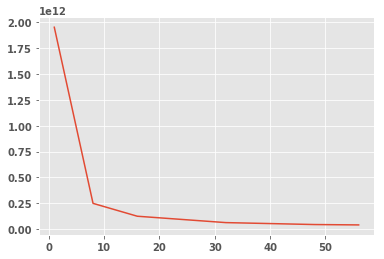

In [6]:
thread_list, tot_cyc_list = scaling_plot(metric_data)

[1, 8, 16, 32, 48, 56]


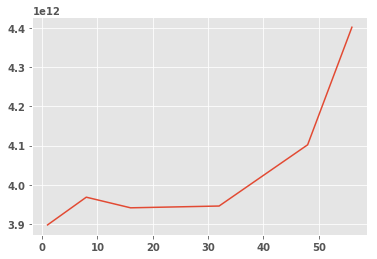

In [7]:
tot_cyc_data = select_metric_from_scaling(metric_data, 'PAPI_TOT_CYC')
    
thread_list  = sorted(tot_cyc_data.keys())
print(thread_list)
tot_cyc_list = [tot_cyc_data[kt]['Exclusive'].sum() for kt in thread_list]

plt = matplotlib.pyplot.plot(thread_list, tot_cyc_list)


### Scaling with max cycles per thread vs the thread count

[1, 8, 16, 32, 48, 56]


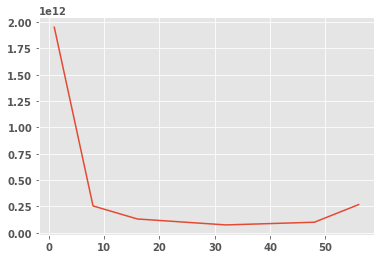

In [8]:
tot_cyc_data = select_metric_from_scaling(metric_data, 'PAPI_TOT_CYC')
    
thread_list  = sorted(tot_cyc_data.keys())
print(thread_list)
max_cyc_list = [tot_cyc_data[kt]['Inclusive'].max() for kt in thread_list]

plt = matplotlib.pyplot.plot(thread_list, max_cyc_list)

### Scaling with average cycles per thread vs the thread count

[1, 8, 16, 32, 48, 56]


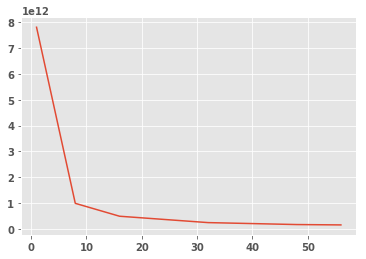

In [9]:
tot_cyc_data = select_metric_from_scaling(metric_data, 'PAPI_TOT_CYC')
    
thread_list  = sorted(tot_cyc_data.keys())
print(thread_list)
avg_cyc_list = [(tot_cyc_data[kt]['Inclusive'].sum())/kt for kt in thread_list]

plt = matplotlib.pyplot.plot(thread_list, avg_cyc_list)

### Cycles used by each thread of each thread count

1


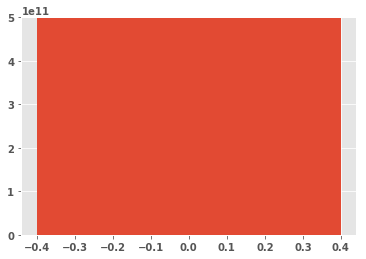

8


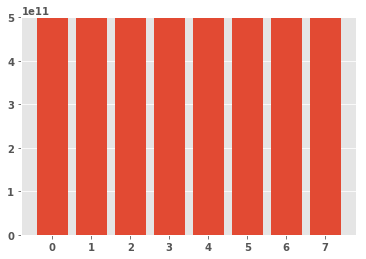

16


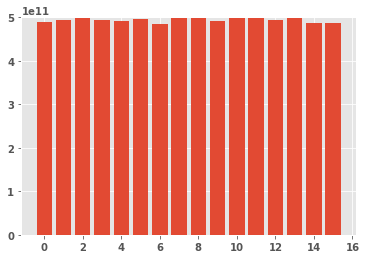

32


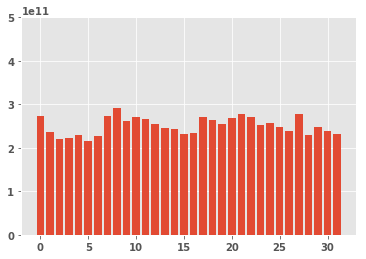

48


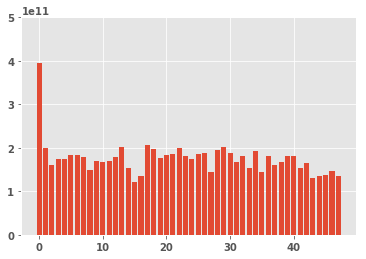

56


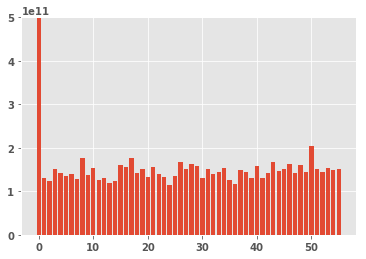

In [10]:
thread_cyc_data = get_thread_level_metric_scaling(tot_cyc_data)

for kt in thread_list:
    print kt
    data = list(thread_cyc_data[kt])
    matplotlib.pyplot.bar(range(len(data)), data)
    matplotlib.pyplot.ylim(ymax=500000000000) 
    matplotlib.pyplot.show()

### L1 Missrate vs thread count

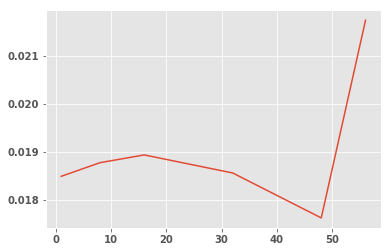

In [11]:
L1A_data = select_metric_from_scaling(metric_data, 'PAPI_LST_INS')
L1M_data = select_metric_from_scaling(metric_data, 'PAPI_L1_TCM')
    
L1_MR_list = [L1M_data[kt]['Inclusive'].sum() / L1A_data[kt]['Inclusive'].sum() for kt in thread_list]

plt = matplotlib.pyplot.plot(thread_list, L1_MR_list)

### L1 Miss rate by each thread of each thread count

1


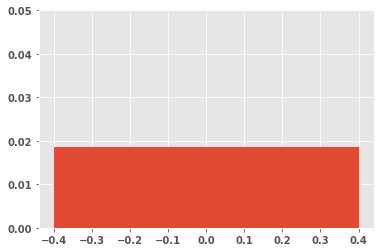

8


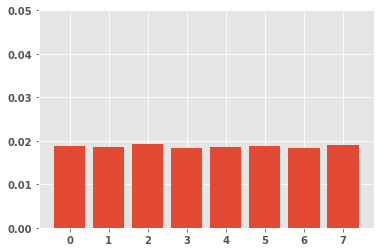

16


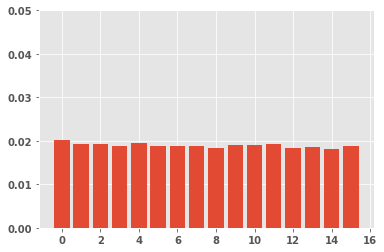

32


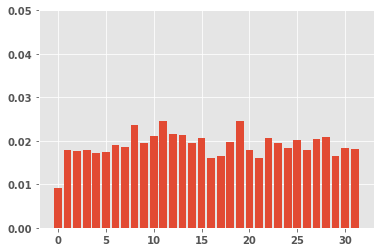

48


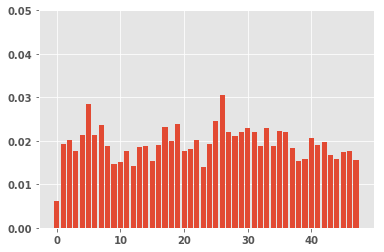

56


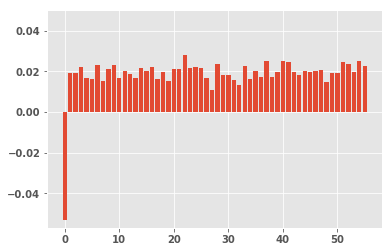

In [12]:
thread_L1A_data = get_thread_level_metric_scaling(L1A_data)
thread_L1M_data = get_thread_level_metric_scaling(L1M_data)

MR_data = {}
for kt in thread_list:
    MR_data[kt] = thread_L1M_data[kt] / thread_L1A_data[kt]
    
for kt in thread_list:
    print kt
    data = list(MR_data[kt])
    matplotlib.pyplot.bar(range(len(data)), data)
    matplotlib.pyplot.ylim(ymax=0.05)
    matplotlib.pyplot.show()

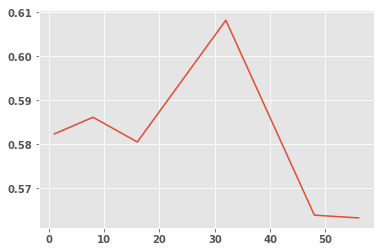

In [13]:
L2A_data = select_metric_from_scaling(metric_data, 'PAPI_L2_TCA')
L2M_data = select_metric_from_scaling(metric_data, 'PAPI_L2_TCM')
    
L2_MR_list = [L2M_data[kt]['Inclusive'].sum() / L2A_data[kt]['Inclusive'].sum() for kt in thread_list]

plt = matplotlib.pyplot.plot(thread_list, L2_MR_list)

1


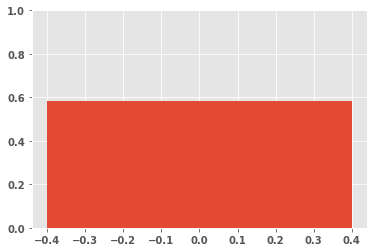

8


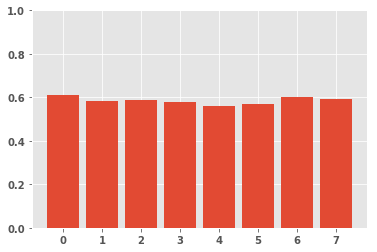

16


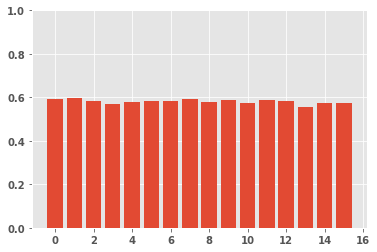

32


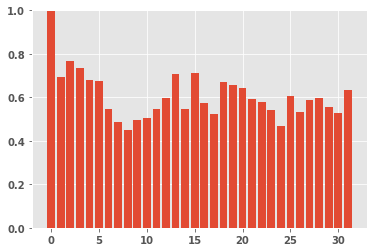

48


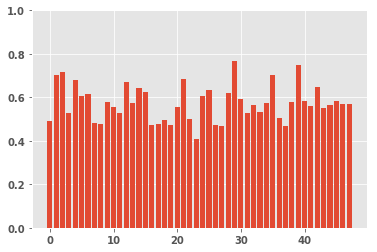

56


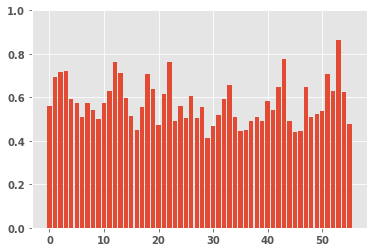

In [14]:
thread_L2A_data = get_thread_level_metric_scaling(L2A_data)
thread_L2M_data = get_thread_level_metric_scaling(L2M_data)

L2_MR_data = {}
for kt in thread_list:
    L2_MR_data[kt] = thread_L2M_data[kt] / thread_L2A_data[kt]
    
for kt in thread_list:
    print kt
    data = list(L2_MR_data[kt])
    matplotlib.pyplot.bar(range(len(data)), data)
    matplotlib.pyplot.ylim(ymax=1)
    matplotlib.pyplot.show()

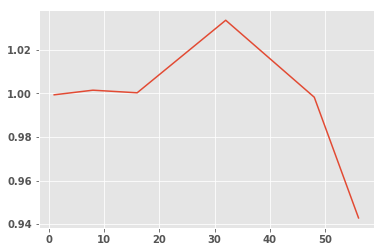

In [15]:
LLA_data = select_metric_from_scaling(metric_data, 'PAPI_L3_TCA')
LLM_data = select_metric_from_scaling(metric_data, 'PAPI_L3_TCM')

# LLA_data = select_metric_from_scaling(metric_data, 'PAPI_NATIVE_LLC_REFERENCES')
# LLM_data = select_metric_from_scaling(metric_data, 'PAPI_NATIVE_LLC_MISSES')
    
LL_MR_list = [L2M_data[kt]['Inclusive'].sum() / LLA_data[kt]['Inclusive'].sum() for kt in thread_list]

plt = matplotlib.pyplot.plot(thread_list, LL_MR_list)

1


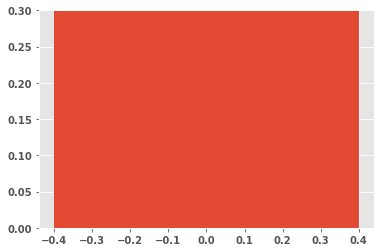

8


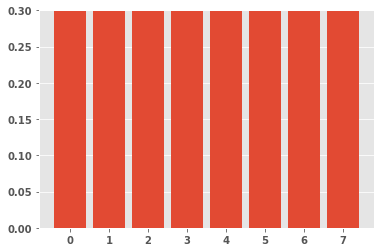

16


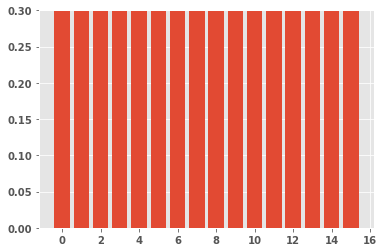

32


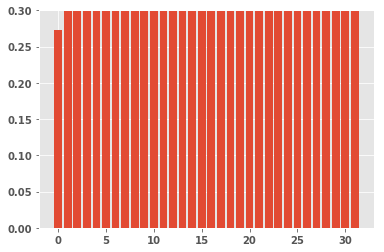

48


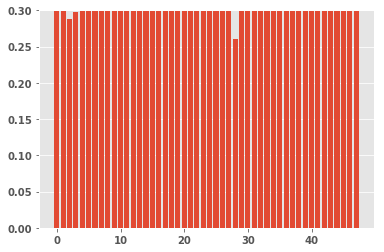

56


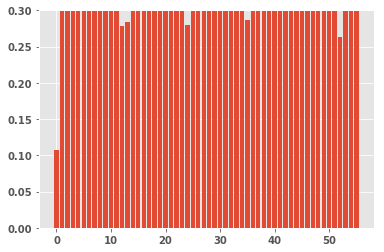

In [16]:
thread_LLA_data = get_thread_level_metric_scaling(LLA_data)
thread_LLM_data = get_thread_level_metric_scaling(LLM_data)

LL_MR_data = {}
for kt in thread_list:
    LL_MR_data[kt] = thread_LLM_data[kt] / thread_LLA_data[kt]
    
for kt in thread_list:
    print kt
    data = list(LL_MR_data[kt])
    matplotlib.pyplot.bar(range(len(data)), data)
    matplotlib.pyplot.ylim(ymax=0.3)
    matplotlib.pyplot.show()

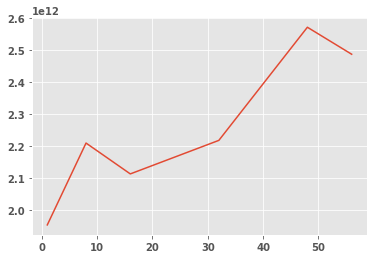

In [17]:
res_stall_data = select_metric_from_scaling(metric_data, 'PAPI_RES_STL')
    
res_stall_list = [res_stall_data[kt]['Inclusive'].sum() for kt in thread_list]

plt = matplotlib.pyplot.plot(thread_list, res_stall_list)

1


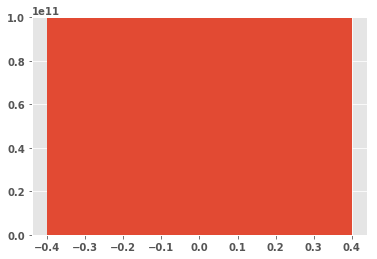

8


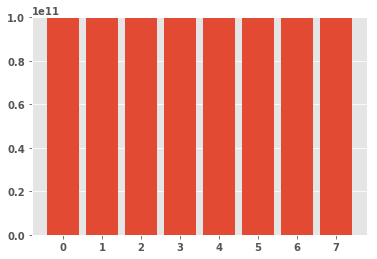

16


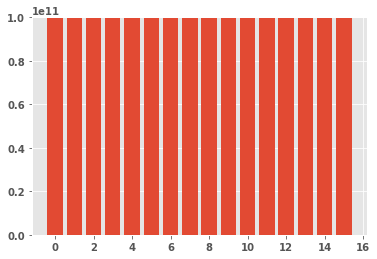

32


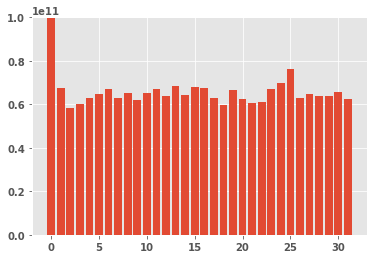

48


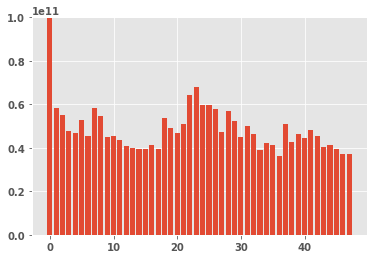

56


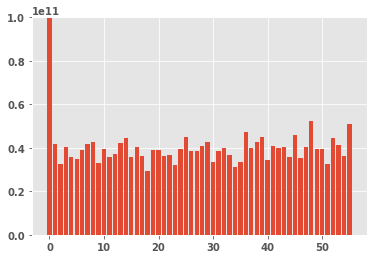

In [18]:
thread_stall_data = get_thread_level_metric_scaling(res_stall_data)
    
for kt in thread_list:
    print kt
    data = list(thread_stall_data[kt])
    matplotlib.pyplot.bar(range(len(data)), data)
    matplotlib.pyplot.ylim(ymax=100000000000)
    matplotlib.pyplot.show()